# Product Cross Selling Recommender System

**Business Problem Statement:**

Our financial services company has a diverse portfolio of investment products, yet the vast majority (99%) of our existing customers hold only one product—the Money Market Fund. Despite a broad array of offerings (Balanced Fund, Dollar Fund, Equity Fund, Fixed Income Fund, and Wealth Fund), our product penetration per customer (PPC) remains exceptionally low. This indicates a significant opportunity to cross-sell additional products to our existing customer base, which would increase customer value, loyalty, and the company’s overall profitability.

Currently, our customers’ data includes key information that could be leveraged to tailor product recommendations. These data points include:
- **Location (town)**
- **Gender**
- **Customer-relationship or beneficiary information** (as customers may have more than one relationship or beneficiary associated with them)
- **Customer age and DOB**
- **Beneficiary age and DOB**

Our goal is to create a user-friendly, intelligent recommender system that can analyze this existing data to suggest additional, relevant financial products to each customer. This system should be able to identify patterns or trends in customer profiles, uncover customer needs, and map those needs to suitable financial products, increasing our PPC in an efficient, cost-effective manner. 

**Objectives:**
1. **Customer Retention and Loyalty**: By offering personalized recommendations, we aim to build deeper, more personalized relationships with our customers, making them more likely to stay with us long-term.
2. **Increased Revenue per Customer**: A successful cross-selling strategy would increase the average number of products per customer, boosting overall portfolio revenue.
3. **User-Friendly Experience**: Ensuring a straightforward, accessible interface for customers to explore new financial products, particularly given that our target customers may have limited experience with financial diversification.

**Project Success Criteria:**
1. Develop a model that accurately predicts the next likely product(s) for each customer based on their profile and behavior.
2. Achieve a measurable increase in the PPC rate by the end of the initial deployment phase.
3. Design an intuitive interface that enhances the customer journey, with minimal friction, to encourage engagement and adoption.

## DATA CLEANING AND PREPARATION

In [1]:
#importing the necessary libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score


In [2]:
# # Extract the CSV file from the zip file
# with zipfile.ZipFile("single_member.zip", 'r') as zip_ref:
#     zip_ref.extractall()  # This will extract to the current directory

In [3]:
#load the dataset
df = pd.read_csv("single_member.csv")
df

,member_no,reg_date,dob,hse_no,gender,town,relationship,beneficiery_dob,portfolio
0,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
1,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
2,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
3,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
4,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
...,...,...,...,...,...,...,...,...,...
7532949,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Money Market
7532950,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Money Market
7532951,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Money Market
7532952,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Balanced Fund


In [4]:
#inspecting the columns in the dataframe
df.columns

Index(['member_no', 'reg_date', 'dob', 'hse_no', 'gender', 'town',
       'relationship', 'beneficiery_dob', 'portfolio'],
      dtype='object')

In [5]:
#checking the unique values from the member_no column
df['member_no'].unique()

array([99996, 99994, 99993, ...,    19,     3,     2], dtype=int64)

In [6]:
#checking the unique values from the gender column
df['gender'].unique()

array(['Female', 'Male', 'FEMALE', nan, 'MALE', 'F', 'M'], dtype=object)

In [7]:
#checking the unique values from the town column
df['town'].unique()

array(['NAIROBI', nan, 'NAIROBI ', 'THIKA', 'NAKURU', 'MOMBASA ',
       'NDANAI ', 'KISUMU', 'KIKUYU', 'JUJA', 'MACHAKOS', 'MERU',
       'KERICHO', 'MUKURWEINI', 'KATANGI', 'THIKA,KIAMBU', 'NANYUKI',
       'RUAI ', 'MALINDI', 'NYAHURURU', 'MUMIAS', 'KAKAMEGA', 'LODWAR',
       'Nairobi ', 'KITENGELA', 'LIMURU', 'THIKA ', 'MIGORI', 'ELDORET',
       'KITUI', 'RUARAKA', 'Ruiru', 'NJORO', 'EMBU', 'SORI', 'NGONG',
       'MASENO', 'GATUNDU', 'KAHURO', 'KILIFI', 'RUIRU', 'KERUGOYA',
       'KARATINA', 'KITALE ', 'MOMBASA', 'BUNGOMA', 'KISII', '-',
       'Nairobi', 'KINAMBA', 'SIAYA', 'KERICHO ', 'KIAMBU', 'KITALE',
       'BUSIA', 'RUNYENJES', 'VILLAGE MARKET', 'Kapsabet', 'KAGWE',
       'NANDI HILLS', 'KUTUS', 'DAGORETTI', 'LITEIN', 'KAJIADO', 'CHUKA',
       'NYERI', 'NAIROBI, NAIROBI', 'Kisumu ', 'KANJUKU', 'EMALI',
       'GILGIL', 'Kiambu ', 'KANGEMA', 'TIRIKI', 'KARATINA ', 'OTHAYA',
       'KARURI ,KIAMBU', 'MURANGA ', 'Mombasa', 'GATUKUYU ', 'MLOLONGO',
       'UTAWALA ', 'KAPE

In [8]:
#checking the unique values from the relationship column
df['relationship'].unique()

array(['Partner', 'Sister', 'Husband ', 'Husband', 'Daughter', 'Brother ',
       'Son', 'Daughter ', 'Wife', 'Father', 'Mother', 'Brother', 'son',
       'mother', 'father', 'Mother ', 'SPOUSE', 'FRIEND', 'Spouse ',
       'WIfe', 'Father ', 'Spouse', 'child', nan, 'Parent', 'wife',
       'Wife ', 'Son ', 'spouse', 'doughter', 'CHILD', 'ParentChild',
       'partner', 'brother', 'sister', 'MotheR', 'Friend', 'Child',
       'Cousin', 'Dad', 'Mum', 'MOTHER', 'WIFE', 'Sister ', 'SON',
       'BROTHER', 'FATHER', 'aunt ', 'Grandmother', 'HUSBAND', 'self',
       'husband', 'husband ', 'Owner', ' Grand daughter', 'Nephew',
       'SP0USE', 'Self', 'parent', 'SISTER', 'NIECE', 'Niece', 'daughter',
       'Sibling', 'DAUGHTER', 'AUNT', 'brother ', '254701361835',
       'Parent ', 'daughter ', 'FAITHER', 'Family ', 'SPOUSE ',
       'Sibling ', 'PARENT', 'CONFIDANT', 'MUM', 'DAD', 'wife ', 'family',
       'Trustee ', 'son ', 'mother ', 'MOTHER ', 'friend', 'spouse ',
       'S0N', 'SISTER

In [9]:
#checking the unique values from the hse_no column
df['hse_no'].unique()

array(['Single Member'], dtype=object)

In [10]:
#checking the unique values from the portfolio column
df['portfolio'].unique()

array(['Money Market', 'Dollar Fund', 'Wealth Fund', 'Equity Fund',
       'Fixed Income', 'Balanced Fund', 'MoneyMarket', nan], dtype=object)

In [11]:
#checking the unique values from the town column
df['town'].unique()

array(['NAIROBI', nan, 'NAIROBI ', 'THIKA', 'NAKURU', 'MOMBASA ',
       'NDANAI ', 'KISUMU', 'KIKUYU', 'JUJA', 'MACHAKOS', 'MERU',
       'KERICHO', 'MUKURWEINI', 'KATANGI', 'THIKA,KIAMBU', 'NANYUKI',
       'RUAI ', 'MALINDI', 'NYAHURURU', 'MUMIAS', 'KAKAMEGA', 'LODWAR',
       'Nairobi ', 'KITENGELA', 'LIMURU', 'THIKA ', 'MIGORI', 'ELDORET',
       'KITUI', 'RUARAKA', 'Ruiru', 'NJORO', 'EMBU', 'SORI', 'NGONG',
       'MASENO', 'GATUNDU', 'KAHURO', 'KILIFI', 'RUIRU', 'KERUGOYA',
       'KARATINA', 'KITALE ', 'MOMBASA', 'BUNGOMA', 'KISII', '-',
       'Nairobi', 'KINAMBA', 'SIAYA', 'KERICHO ', 'KIAMBU', 'KITALE',
       'BUSIA', 'RUNYENJES', 'VILLAGE MARKET', 'Kapsabet', 'KAGWE',
       'NANDI HILLS', 'KUTUS', 'DAGORETTI', 'LITEIN', 'KAJIADO', 'CHUKA',
       'NYERI', 'NAIROBI, NAIROBI', 'Kisumu ', 'KANJUKU', 'EMALI',
       'GILGIL', 'Kiambu ', 'KANGEMA', 'TIRIKI', 'KARATINA ', 'OTHAYA',
       'KARURI ,KIAMBU', 'MURANGA ', 'Mombasa', 'GATUKUYU ', 'MLOLONGO',
       'UTAWALA ', 'KAPE

In [12]:
#inspecting the dataframe for null values
df.isna().sum()

member_no                0
reg_date              1863
dob                  20038
hse_no                   0
gender                4667
town               1048216
relationship       1632933
beneficiery_dob    1086598
portfolio                9
dtype: int64

In [13]:
#inspecting the dataframe duplicate values
df.duplicated().sum()

7407066

In the below code block, we drop duplicated values.

In [14]:
df = df.drop_duplicates()

From our problem statement, we aim to cross sell investment products depending on Age, Gender and Location. Therefore, we are going to drop some columns which are irrelevant. e.g. hse_no, beneficiary_dob,reg_date.

In [15]:
df=df.drop(columns=['reg_date','hse_no'])

In [16]:
#inspecting the null vaues after dropping columns
df.isna().sum()

member_no              0
dob                  238
gender                82
town               15026
relationship       14308
beneficiery_dob    13937
portfolio              4
dtype: int64

In [17]:
#checking for unique values in relationship column
df.relationship.unique()

array(['Partner', 'Sister', 'Husband ', 'Husband', 'Daughter', 'Brother ',
       'Son', 'Daughter ', 'Wife', 'Father', 'Mother', 'Brother', 'son',
       'mother', 'father', 'Mother ', 'SPOUSE', 'FRIEND', 'Spouse ',
       'WIfe', 'Father ', 'Spouse', 'child', nan, 'Parent', 'wife',
       'Wife ', 'Son ', 'spouse', 'doughter', 'CHILD', 'ParentChild',
       'partner', 'brother', 'sister', 'MotheR', 'Friend', 'Child',
       'Cousin', 'Dad', 'Mum', 'MOTHER', 'WIFE', 'Sister ', 'SON',
       'BROTHER', 'FATHER', 'aunt ', 'Grandmother', 'HUSBAND', 'self',
       'husband', 'husband ', 'Owner', ' Grand daughter', 'Nephew',
       'SP0USE', 'Self', 'parent', 'SISTER', 'NIECE', 'Niece', 'daughter',
       'Sibling', 'DAUGHTER', 'AUNT', 'brother ', '254701361835',
       'Parent ', 'daughter ', 'FAITHER', 'Family ', 'SPOUSE ',
       'Sibling ', 'PARENT', 'CONFIDANT', 'MUM', 'DAD', 'wife ', 'family',
       'Trustee ', 'son ', 'mother ', 'MOTHER ', 'friend', 'spouse ',
       'S0N', 'SISTER

In [18]:
# Convert values in the 'relationship' column to lowercase and remove any extra spaces
df['relationship'] = df['relationship'].str.lower().str.strip()

# Get the counts of each unique value in the 'relationship' column,
# then format the output as a single line string
df['relationship'].value_counts().to_string().replace("\n", " ")

"mother                  18900 son                     18207 daughter                18010 sister                  12234 wife                    11190 husband                  9563 brother                  7768 father                   6738 spouse                   3311 child                    1567 parent                    627 friend                    393 niece                     369 nephew                    313 cousin                    309 aunt                      220 partner                   203 sibling                   199 fiance                    137 guardian                  117 fiancee                   100 uncle                      85 grandson                   74 grandmother                61 family                     51 self                       42 -                          40 estate                     39 grand daughter             31 dad                        29 granddaughter              29 mum                        27 girlfriend                 26 doughter 

In [19]:
# Replace any missing values in the 'relationship' column with 'son'
df['relationship'] = df['relationship'].fillna('son')

# Check if there are any remaining missing values in the 'relationship' column
df['relationship'].isna().sum()


0

To organize and standardize relationship values in the dataset, we define categories for mapping different variations of relationship terms. This approach creates a consistent structure by grouping terms like "spouse," "child," "sibling," etc., into predefined categories. By applying this mapping, we ensure that any variations in spelling, formatting, or synonymous terms are aligned under a single label.

The following code accomplishes this by:

Defining a dictionary (relationship_map) that assigns potential variations of relationship terms to specific categories.
Creating a function (map_relationship) that checks each entry in the relationship column against the keywords in relationship_map.
Applying this function to the column to classify each entry according to the defined categories.
Finally, we display the count of values in each category to confirm the classification distribution.

In [20]:
# Convert all entries to lower case and strip whitespace for uniformity
df['relationship'] = df['relationship'].str.lower().str.strip()

# Mapping dictionary
relationship_map = {
    'partner': [
        'partner', 'spouse', 'sp0use','husband', 'wife', 'fiancee', 'ex-wife', 'spouce', 'fiancé',
        'husband ', 'sponse', 'spouse ', 'wiFe', 'wifE', 'wife ', 'spouse', 'married', 'marriage',
        'husband/spouse', 'ex-wife', 'fiance ', 'fiance', 'married ', 'myson', 'baby mama ',
        'fiancee ', 'souse', 'hubby', 'dating', 'boyfriend', 'girlfriend', 'ex wife', 'boyfriend ',
        'girlfriend ', 'wife/guardian', 'ex husband', 'girl friend', 'fiancée', 'sopouse', 'spoudse',
        'soPOUSE', 'spause', 'sposue', 'ex husband', 'love', 'b/f', 'g/f', 'divorcee', 'ex spouse',
        'bf', 'gf', 'b/f', 'g/f', 'fiancé ', 'domesticpartner', 'domestic partner', 'dating', 'exwife',
        'exhusband', 'wive', 'husb', 'exspouse', 'partner ', 'significant other', 'fiancee','companion','Partner',
        'Husband ', 'Husband',  'Wife',   'SPOUSE' , 'Spouse ', 'WIfe', 'Spouse',  'wife', 'Wife ', 'spouse', 'partner',
        'HUSBAND', 'husband', 'husband ',  'SP0USE' , 'SPOUSE ',  'wife ',
        'spouse ', 'Partner ' , 'FIANCEE', 'Fiancee',  'HUSBAND ',  'FIANCE', 
        'wIFE', 'PARTNER',  'Domestic Partner', 'PATNER', 'Fiance ', 'PARTNER ',  'hUSBAND',  'Boyfriend ',
        'WIFE ', 'fiancee', 'JOINT PARTNER', 'Fiancé ' , 'Husband/spouse', 'SPOUCE',  'Patner', 'Spouce',  
        'Fiance', 'BOYFRIEND', 'EX-WIFE',  'PARNT',  'GIRLFRIED'
    ],
    'child': [
        'child', 'kid', 'daughter', 'son', 'children', 'daughter33', 'doughter', 'daugther', 'doughter ',
        'daugther', 'son ', 'daughter ', 'child minor', 'kids', 'baby', 'infant', 'toddler', 'sonS',
        'minor', 'child ', 'son/sister', 'chid', 'newborn', 'son/brother', 'childnephew',
        'chils', 'chiLD', 'kID', 'dau`', 'daugher', 'childnephew', 'my son','child', 'son', 'dau', 
        'daughter', 'daughter33', 'my son', 'infant', 'childnephew', 'kids', 'baby', 'ChiLD', 'CHID',
        'sON', 'cHILS', 'CHID', 'CHIILD', 'KID', 'FOSTER' 'DAUGHTER', 'CHILD MINOR', 'MINOR', 'CHILDREN', 
        'SOM', 'CHILDREN', 'JUNIOR', 'BABY',  'CHIL', 'DAUGHTER/CHILDDAUGHER', 'CHILF', 'DOUGHTER', 'DAIGHTER', 
        'DAUGHTE', 'DAUGHETR', 'S0N','MYSON','child','CHILD','Child ','DAUGHTER/CHILD','child ','CHILD MINOR',
        'CHILD ','children','CHILDREN','ChILD','ChiLD'
    ],
    'parent': [
        'mother', 'mom', 'mum', 'father', 'dad', 'parent', 'parents', 'mother ', 'father ', 'mOTHER',
        'dad ', 'mum ', 'mom ', 'mummy', 'daddy', 'papa', 'mama', 'mother in law', 'father in law',
        'mothers', 'fathers', 'moms', 'mums', 'father-in-law', 'mother-in-law', 'mommy', 'dadi', 'momi',
        'parent ', 'mother to son', 'mother of child', 'parents', 'mother- guardian', 'father - guardian',
        'parentchild', 'parental', 'parenthood', 'parenting', 'mother IN LAW', 'mom in law', 'dad in law',
        'mum in law', 'parenting', 'fatherhood', 'motherhood', 'parent ', 'grandparent', 'step mother',
        'step father', 'step-mother', 'step-father','Parent', 'Parents', 'Mother', 'Mothers', 'Mom', 'Mum', 
        'Father', 'DAD', 'Dad', 'Guardian', 'Grandmother', 'Grandfather', 'Step-mother', 'Step-father', 'Foster parent',
        'Mother-in-law', 'Father-in-law', 'ParentChild', 'Mama', 'Mummy', 'Dadi', 'Mother TO SON', 'PARENT', 'MOther'
    ],
    'self': [
        'self', 'owner', 'me', 'myself', 'self ', 'owner ', 'i', 'myself ', 'personal', 'individual',
        'own', 'my own', 'self-employed', 'proprietor', 'me ', 'self employed', 'self own', 'personal account',
        'my account', 'own account'
    ],
    'guardian': [
        'guardian', 'custodian', 'trustee', 'guard', 'guardian ', 'custodian ', 'trustee ', 'guard ',
        'legal guardian', 'guardianship', 'custodianship', 'trusteeship', 'protector', 'caregiver',
        'conservator','conservator', 'foster parent', 'foster guardian', 'legal custodian', 'guardian-mother', 'guardian father'
    ],
    'sibling': [
        'siblings', 'brother', 'sister', 'sibling', 'brother ', 'sister ', 'bro', 'sis', 'brothers', 'sisters',
        'sibling ', 'brother-in-law', 'sister-in-law', 'sibling in law', 'brother and sister', 'sibbling',
        'siBLING', 'sibblings', 'sister in law', 'brother in law', 'sister/guardian', 'sister - guardian',
        'sister-guardian', 'bros', 'sisses', 'step-sister', 'step-brother', 'half-sister', 'half-brother', 'broski','Sister', 'Brother ','brother', 'sister',
       'Sister ', 'SISTER','Sibling', 'brother ','Sibling ','SISTER ','Sistet', 'Bro', 'Sis', 'SiBLING',
        'SIBLING',  's0n', 'sister ''sISTER', 'sisiter', ' BROTHER','BRother', 'SisteR', 'SIS', 
       'som',
       'Sister- Custodian', 
       'SIIBLING', 'SIBLINGS','Brother and sister',
       'Sibbling'
    ],
    'relative': [
        'cousin', 'nephew', 'grand child', 'niece', 'grandmother', 'granddaughter', 'grandson', 'grandfather', 'uncles', 'aunties',
        'aunt', 'uncle', 'granny', 'grandparent', 'grand child', 'relative', 'relatives', 'cousins', 'uncles',
        'aunties', 'aunts', 'grandparents', 'great grandmother', 'great grandfather', 'grand children', 'extended family',
        'grandmother ', 'grandfather ', 'nephew ', 'niece ', 'cousin ', 'aunt ', 'uncle ', 'granny ', 'granddaughter ',
        'grandson ', 'grandchild', 'grandchild ', 'grandchildren', 'grandkids', 'great grandparent', 'ancestors', 'descendants',
        'kin', 'kinship', 'next of kin', 'in-laws', 'inlaw', 'in laws', 'extended relatives', 'b inlaw', 'in law','family tree', 'Cousin', ' Grand daughter', 'Nephew', 'NIECE', 'Niece', 'AUNT', 'relative', 'AUNTIE', 'B INLAW', 'COUSIN', 'aunt', 'UNCLE', 'GRAND SON', 'Nephew ', 'Cousin ', 'nephew', 'GRAND DAUGHTER', 'Niece ', 'granddaughter', 'grandson', 'RELATIVE', 'Daughter-in-law ', 'GRANDMOTHER', 'Relative ', 'uncle',
'NEPHEW', 'Grand daughter', 'DAUGHTER-IN-LAW', 'COUSN', 'Uncle', 'Granddaughter ', 'Aunt ', 'cousin', 'GRANDSON ', 'uncle ', 'AUNTY', 'FATHER-IN-LAW', 'GRAND FATHER', 'DGRAND DAUGHTER', 'GRAND MOTHER', 'UN,CLE', 'GRAND CHILD', 'Sister in law', 'Grand Daughter', 'GRANDDAUGTER', 'NiecE', 'Brother-IN-LAW', 'Grand mother', 'GRANDFATHER', 'Daughter in law', 'Sister-IN-LAW', 'GRAND-DAUGHTER', 'GRANNY', 
'GRANDCHILD', 'Aunty', 'Cousins', 'Cousins ', 'Auntie', 'GRANDPA', 'Brother in Law', 'IN LAW', 'Granddaughter', 'niece', 'Grand Son', 'Sister-in law', 'CLOUSIN', 'GRANSON', 'Sister IN LAW', 'Brother-in-law', 'Sister-Inlaw', 'Brother in law', 'GRAND-MOTHER', 'Grand-mother', 'Mother-in-law', 'SISTER IN LAW ', 'Grand mother ', 'Childnephew', 'Grand daughter ', 'auntie', 'In law', 'Sister in-law', 'Aunty '
    ],
    'friends': ['friend','closefriend', 'confidant', 'friend ',
        'peers', 'acquaintance', 'comrade', 'pal', 'buddy', 'mate', 'fellow', 'ally', 'supporter',
        'confidante', 'friend of the family', 'family friend',
        'peer', 'companion', 'companions'
    ],
    'professional':['colleague', 'coworker', 'partner in law',
        'associate', 'advisor', 'mentor', 'colleague ', 'coworker ',
        'associate ', 'colleague', 'professional', 'mentor', 'adviser', 'counselor', 'legal representative', 'executor', 'business partner',
        'co-worker', 'workmate', 'teammate',
        'partner in business', 'business associate', 'collaborator', 'collegue','estate'
    ],
    'other': ['spiritual advisor','sponsor'
    ]
}

# Function to apply the mapping
def map_relationship(value):
    for category, keywords in relationship_map.items():
        if any(keyword == value for keyword in keywords):
            return category
    return 'other'  # Default category if no matches found

# Apply the mapping function to the 'relationship' column
df['relationship'] = df['relationship'].apply(map_relationship)

# Show the value counts of each category
print(df['relationship'].value_counts())

child           52152
parent          26352
partner         24578
sibling         20240
relative         1534
friends           396
other             392
guardian          128
professional       67
self               49
Name: relationship, dtype: int64


In [21]:
#checking the columns in the dataframe
df.columns

Index(['member_no', 'dob', 'gender', 'town', 'relationship', 'beneficiery_dob',
       'portfolio'],
      dtype='object')

In [22]:
#inspecting the value_counts in the gender column
df.gender.value_counts()

Female    83178
Male      42480
F            92
M            48
FEMALE        4
MALE          4
Name: gender, dtype: int64

In [23]:
#checking for null values
df.gender.isna().sum()

82

In [24]:
#fill the null values with the 'Female' gender
df['gender']=df.gender.fillna('Female')
df['gender'].isna().sum()

0

To standardize entries in the gender column, we create a dictionary to map various formats of "Male" and "Female" into consistent labels. This step ensures uniformity across the dataset, which is essential for accurate analysis.

The process involves:

Defining a gender_map dictionary where different versions of "Male" and "Female" are assigned to a single, standardized label.
Using the replace function to apply this mapping to the gender column and store the cleaned values in a new column, gender_mapped.
This streamlined approach produces a clean and uniform gender_mapped column ready for analysis.

In [25]:
gender_map = {
    'Female':'Female','F':'Female','FEMALE':'Female',
    'Male':'Male','M':'Male','MALE':'Male',
}

df['gender_mapped'] = df['gender'].replace(gender_map)

In [26]:
#inspecting the cleaned df
df.head()

,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped
0,99996,1998-04-06 00:00:00,Female,NAIROBI,partner,1998-01-26,Money Market,Female
14,99996,1998-04-06 00:00:00,Female,NAIROBI,sibling,2001-03-04,Money Market,Female
28,99994,1966-01-01 00:00:00,Female,NaN,partner,1962-01-01,Money Market,Female
40,99993,1974-01-01 00:00:00,Female,NAIROBI,partner,1970-09-29,Money Market,Female
70,99993,1974-01-01 00:00:00,Female,NAIROBI,child,1994-01-01,Money Market,Female


In [27]:
#age distribution based on dob(date of birth)
df.dob.value_counts()

1962-01-01             541
1960-01-01             360
1968-01-01             320
1974-01-01             311
1970-01-01             311
                      ... 
1970-04-13               1
1960-09-02               1
2004-01-14               1
1958-04-29               1
2000-02-29 21:00:00      1
Name: dob, Length: 19092, dtype: int64

In [28]:
#age distribution based on beneficiary_dob(date of birth)
df.beneficiery_dob.value_counts()

1899-12-30             1854
1962-01-01              584
1970-01-01              562
1960-01-01              488
1963-01-01              475
                       ... 
1989-11-12 00:00:00       1
1952-11-06                1
1988-06-10 00:00:00       1
1952-12-05                1
1983-05-22 00:00:00       1
Name: beneficiery_dob, Length: 27488, dtype: int64

In [29]:
#fill with the modal age
df['dob'] = df.dob.fillna('1962-01-01')
df.dob.isna().sum()

0

---

To compute ages from the dates of birth in our dataset, we:

1. **Convert Dates of Birth:** The `dob` and `beneficiery_dob` columns are first converted to datetime format to ensure proper date handling. If a date cannot be converted, it is set to `NaT` (missing).
  
2. **Define Age Calculation Function:** A helper function, `calculate_age`, computes the age by subtracting the birth year from the current year and adjusting for birthdays that have not yet occurred this year.

3. **Apply Function to Columns:** The function is applied to both `dob` and `beneficiery_dob` to create two new columns: `member_age` and `beneficiery_age`, which store the calculated ages.

Finally, the resulting columns are previewed to verify successful age computation.

In [30]:
# Convert the dob column to datetime format
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Function to calculate age
def calculate_age(birth_date):
    if pd.isnull(birth_date):
        return None
    today = datetime.today()
    return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))

# Apply the function to calculate member age
df['member_age'] = df['dob'].apply(calculate_age)

# Convert beneficiery_dob column to datetime and calculate beneficiary age similarly
df['beneficiery_dob'] = pd.to_datetime(df['beneficiery_dob'], errors='coerce')
df['beneficiery_age'] = df['beneficiery_dob'].apply(calculate_age)

# Check results
print(df[['dob', 'member_age', 'beneficiery_dob', 'beneficiery_age']].head())

          dob  member_age beneficiery_dob  beneficiery_age
0  1998-04-06          26      1998-01-26             26.0
14 1998-04-06          26      2001-03-04             23.0
28 1966-01-01          58      1962-01-01             62.0
40 1974-01-01          50      1970-09-29             54.0
70 1974-01-01          50      1994-01-01             30.0


In [31]:
# Display summary statistics for the 'beneficiery_age' column to understand the age distribution of beneficiaries
df.beneficiery_age.describe()

count    111951.000000
mean         37.961296
std          22.107604
min        -178.000000
25%          24.000000
50%          36.000000
75%          53.000000
max         329.000000
Name: beneficiery_age, dtype: float64

In [32]:
#display the portfolio allocation 
df.portfolio.value_counts()

Money Market     119710
Equity Fund        2014
Dollar Fund        1480
Balanced Fund      1180
Fixed Income       1101
Wealth Fund         398
MoneyMarket           1
Name: portfolio, dtype: int64

In [33]:
#fill with the mode
df['portfolio']=df.portfolio.fillna('Money Market')
df.portfolio.isna().sum()

0

---

1. **Portfolio Mapping:** It defines a dictionary (`portfolio_map`) that standardizes various portfolio names in the `portfolio` column. For instance, entries like "Money Mrket" and "MoneyMarket" are all mapped to "Money Market," ensuring consistency across the dataset.

2. **Replace Portfolio Values:** The `replace` function is then applied to the `portfolio` column, replacing any of the portfolio variations with their standardized labels as defined in the `portfolio_map` dictionary.

3. **Create New Column:** The standardized portfolio names are saved in a new column, `portfolio_map`, in the dataframe.



In [34]:
#clean up the portfolio column
portfolio_map ={
    'Money Mrket':'Money Market','MoneyMarket':'Money Market',
    'Equity Fund':'Equity Fund',
    'Dollar Fund':'Dollar Fund',
    'Balanced Fund':'Balanced Fund',
    'Fixed Income':'Fixed Income',
    'Wealth Fund':'Wealth Fund',
}
df['portfolio_map'] = df['portfolio'].replace(portfolio_map)

In [35]:
#check the new_df
df.head()

,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped,member_age,beneficiery_age,portfolio_map
0,99996,1998-04-06,Female,NAIROBI,partner,1998-01-26,Money Market,Female,26,26.0,Money Market
14,99996,1998-04-06,Female,NAIROBI,sibling,2001-03-04,Money Market,Female,26,23.0,Money Market
28,99994,1966-01-01,Female,NaN,partner,1962-01-01,Money Market,Female,58,62.0,Money Market
40,99993,1974-01-01,Female,NAIROBI,partner,1970-09-29,Money Market,Female,50,54.0,Money Market
70,99993,1974-01-01,Female,NAIROBI,child,1994-01-01,Money Market,Female,50,30.0,Money Market


In [36]:
#inspecting the null values in the town column
df.town.isna().sum()

15026

In [37]:
#inspecting the value_counts in the town column
df.town.value_counts()

NAIROBI              56997
Nairobi              10261
THIKA                 3000
NAKURU                2608
MOMBASA               2440
                     ...  
LAARE                    1
KAP                      1
KHAYEGA                  1
GITHURAI                 1
BURUBURU NAIROBI         1
Name: town, Length: 973, dtype: int64

In [38]:
#fill the null values with unknown
df['town'] = df.town.fillna('Unknown')
df.town.isna().sum()

0

In [39]:
df.head()

,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped,member_age,beneficiery_age,portfolio_map
0,99996,1998-04-06,Female,NAIROBI,partner,1998-01-26,Money Market,Female,26,26.0,Money Market
14,99996,1998-04-06,Female,NAIROBI,sibling,2001-03-04,Money Market,Female,26,23.0,Money Market
28,99994,1966-01-01,Female,Unknown,partner,1962-01-01,Money Market,Female,58,62.0,Money Market
40,99993,1974-01-01,Female,NAIROBI,partner,1970-09-29,Money Market,Female,50,54.0,Money Market
70,99993,1974-01-01,Female,NAIROBI,child,1994-01-01,Money Market,Female,50,30.0,Money Market


In [40]:
# Drop unnecessary columns ('dob', 'gender', 'portfolio', 'beneficiery_dob') from the dataframe
new_df=df.drop(columns=['dob','gender','portfolio','beneficiery_dob'])
new_df.head()

,member_no,town,relationship,gender_mapped,member_age,beneficiery_age,portfolio_map
0,99996,NAIROBI,partner,Female,26,26.0,Money Market
14,99996,NAIROBI,sibling,Female,26,23.0,Money Market
28,99994,Unknown,partner,Female,58,62.0,Money Market
40,99993,NAIROBI,partner,Female,50,54.0,Money Market
70,99993,NAIROBI,child,Female,50,30.0,Money Market


In [41]:
#fill null values with the mode
new_df['member_age'].fillna(new_df['member_age'].mode()[0], inplace=True)
new_df['beneficiery_age'].fillna(new_df['beneficiery_age'].mode()[0], inplace=True)

In [42]:
# Set reasonable age bounds
lower_bound = 0
upper_bound = 100

# Create a copy of original ages for comparison if needed
original_ages = new_df['beneficiery_age'].copy()

# Replace outliers by clipping to bounds
new_df['beneficiery_age'] = new_df['beneficiery_age'].clip(lower=lower_bound, upper=upper_bound)

## DATA VISUALIZATION

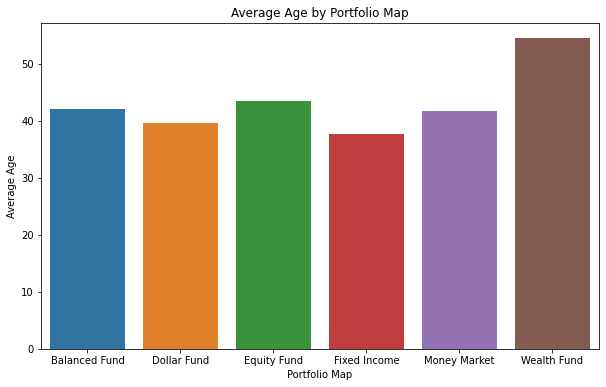

In [43]:
average_age = new_df.groupby('portfolio_map')['member_age'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='portfolio_map', y='member_age', data=average_age)
plt.title('Average Age by Portfolio Map')
plt.xlabel('Portfolio Map')
plt.ylabel('Average Age')
plt.show()


The output is a bar plot showing the average age for each portfolio type.
Each bar represents the average age of members who belong to that specific portfolio, allowing you to quickly compare the average ages across different portfolio categories.
The resulting plot gives insights into the age distribution for each portfolio, highlighting which portfolios are associated with older or younger members.

In [44]:
#check columns
new_df.columns

Index(['member_no', 'town', 'relationship', 'gender_mapped', 'member_age',
       'beneficiery_age', 'portfolio_map'],
      dtype='object')

In [45]:
#convert the cleaned data to csv
new_df.to_csv('cleaned_data.csv', index=False)

In [46]:
#inspecting the preprocessed dataframe
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125888 entries, 0 to 7532842
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   member_no        125888 non-null  int64  
 1   town             125888 non-null  object 
 2   relationship     125888 non-null  object 
 3   gender_mapped    125888 non-null  object 
 4   member_age       125888 non-null  int64  
 5   beneficiery_age  125888 non-null  float64
 6   portfolio_map    125888 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 7.7+ MB


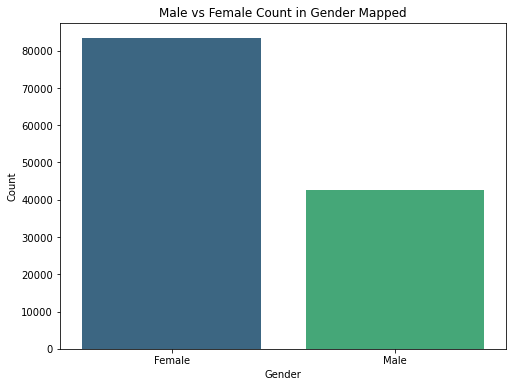

In [47]:
plt.figure(figsize=(8, 6))
sns.countplot(data=new_df, x='gender_mapped', palette='viridis')
plt.title('Male vs Female Count in Gender Mapped')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

This plot gives a clear visual comparison of how many male and female entries are present in the dataset after the gender mapping process.
The resulting plot allows for an easy comparison of the number of male versus female entries in the dataset, making it visually straightforward to assess gender distribution.

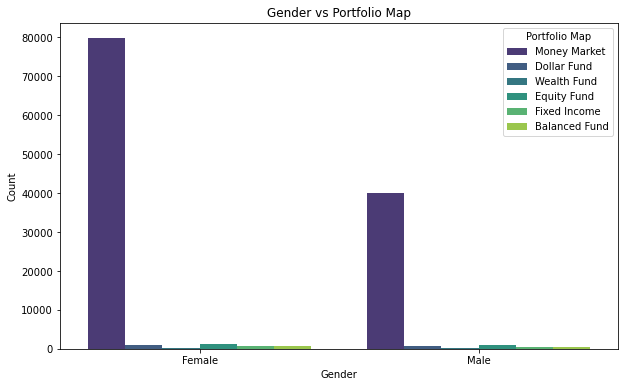

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(data=new_df, x='gender_mapped', hue='portfolio_map', palette='viridis')
plt.title('Gender vs Portfolio Map')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Portfolio Map')
plt.show()

This plot provides a clear visual comparison of how genders are distributed across different portfolio categories, helping to understand the intersection of gender and portfolio preferences. It allows you to see if certain portfolio types are more favored by one gender over the other or if the distribution is relatively balanced.

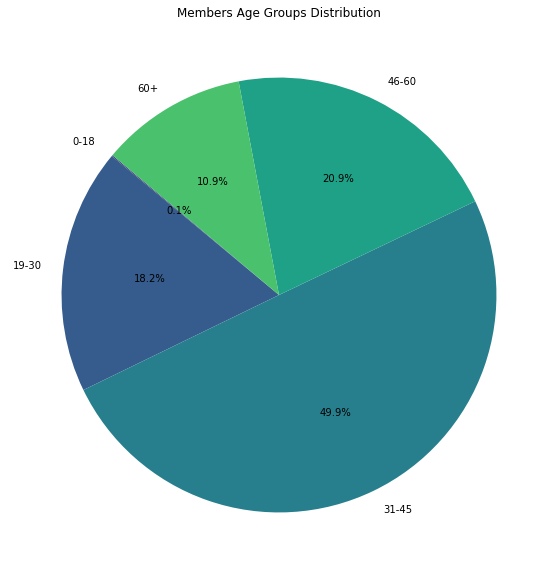

In [49]:
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '19-30', '31-45', '46-60', '60+']
new_df['age_group'] = pd.cut(new_df['member_age'], bins=age_bins, labels=age_labels)
age_counts = new_df['age_group'].value_counts().sort_index()
plt.figure(figsize=(10, 10))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Members Age Groups Distribution')
plt.show()

Each segment of the pie chart represents one of these age groups.
The size of each segment corresponds to the percentage of members that fall into each age group.
The color palette viridis provides visually distinguishable colors for each segment.
The autopct option displays the percentage of total members in each age group directly on the chart, making it easy to compare the distribution across groups.
This pie chart provides a clear visual of the age distribution among the members, helping to identify which age groups are the most and least represented in the dataset.

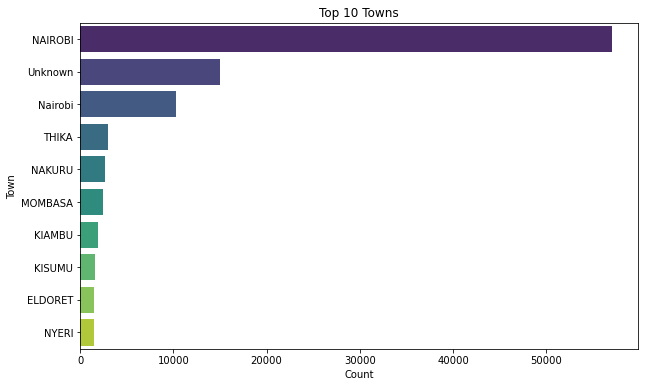

In [50]:
top_10_towns = new_df['town'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_towns.values, y=top_10_towns.index, palette='viridis')
plt.title('Top 10 Towns')
plt.xlabel('Count')
plt.ylabel('Town')
plt.show()

overview of the most common towns in the dataset, highlighting their relative frequencies.

## MODELING

In [51]:
#inspect the new_df
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125888 entries, 0 to 7532842
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   member_no        125888 non-null  int64   
 1   town             125888 non-null  object  
 2   relationship     125888 non-null  object  
 3   gender_mapped    125888 non-null  object  
 4   member_age       125888 non-null  int64   
 5   beneficiery_age  125888 non-null  float64 
 6   portfolio_map    125888 non-null  object  
 7   age_group        125808 non-null  category
dtypes: category(1), float64(1), int64(2), object(4)
memory usage: 12.8+ MB


In [52]:
#check the first entries in the dataframe
new_df.head()

,member_no,town,relationship,gender_mapped,member_age,beneficiery_age,portfolio_map,age_group
0,99996,NAIROBI,partner,Female,26,26.0,Money Market,19-30
14,99996,NAIROBI,sibling,Female,26,23.0,Money Market,19-30
28,99994,Unknown,partner,Female,58,62.0,Money Market,46-60
40,99993,NAIROBI,partner,Female,50,54.0,Money Market,46-60
70,99993,NAIROBI,child,Female,50,30.0,Money Market,46-60


In [53]:

# Create a feature matrix combining the relevant columns
X = new_df[['member_age', 'beneficiery_age', 'age_group', 'gender_mapped']]

# Convert the feature columns to a single string for each row
X['features'] = X.astype(str).sum(axis=1)

# Create a TF-IDF matrix from the features
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X['features'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, new_df['portfolio_map'], test_size=0.2, random_state=42)




<ipython-input-53-c464198fbbef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['features'] = X.astype(str).sum(axis=1)


In [54]:
# Train the Nearest Neighbors model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(X_train)



NearestNeighbors(algorithm='brute', metric='cosine')

In [55]:
def get_recommendations(member_features, n=5):
    # Get distances and indices of the nearest neighbors
    distances, indices = model.kneighbors(member_features, n_neighbors=n+1)
    
    # Retrieve the original portfolio information from `new_df` using indices
    # Exclude the first column of `indices` since it's the item itself
    recommended_portfolios = new_df.iloc[indices[0, 1:]]['portfolio_map'].tolist()
    
    return recommended_portfolios

In [56]:

# Make predictions on the test set
y_pred = []
for i in range(X_test.shape[0]):
    member = X_test[i].toarray()
    recommendations = get_recommendations(member.reshape(1, -1), n=1)
    y_pred.append(recommendations[0])  # Get the top recommendation

# Calculate accuracy by comparing the predicted product to the actual product
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.79


RULE BASED ADDED

In [57]:
def get_recommendations(member_features, member_no, n=5):
    # Fetch member's details
    member_row = new_df.loc[new_df['member_no'] == member_no].iloc[0]
    member_beneficiary_age = member_row['beneficiery_age']
    member_age_group = member_row['age_group']
    member_town = member_row['town']
    member_gender = member_row['gender_mapped']
    member_current_products = set(new_df.loc[new_df['member_no'] == member_no, 'portfolio_map'].values)
    
    recommended_products = []

    # Rule 1: Recommend based on beneficiary age (Student and Junior Accounts)
    #if 18 <= member_beneficiary_age <= 25:
    if  member_beneficiary_age >= 18 and  member_beneficiary_age <= 25:
        recommended_products.append("Student Account")
    elif member_beneficiary_age < 18:
        recommended_products.append("Junior Account")

    # Rule 2: Recommend popular products within the same age group
    age_group_products = (
        new_df[new_df['age_group'] == member_age_group]
        .portfolio_map.value_counts()
        .index
        .tolist()
    )
    for product in age_group_products:
        if product not in member_current_products and product not in recommended_products:
            recommended_products.append(product)
        if len(recommended_products) >= n:
            return recommended_products[:n]

    # Rule 3: Recommend popular products in the same town
    town_products = (
        new_df[new_df['town'] == member_town]
        .portfolio_map.value_counts()
        .index
        .tolist()
    )
    for product in town_products:
        if product not in member_current_products and product not in recommended_products:
            recommended_products.append(product)
        if len(recommended_products) >= n:
            return recommended_products[:n]
        
    gender_products = (
        new_df[new_df['gender_mapped']== member_gender]
        .portfolio_map.value_counts()
        .index
        .tolist()
    )
    for product in gender_products:
        if product not in member_current_products and product not in recommended_products:
            recommended_products.append(product)
        if len(recommended_products) >= n:
            return recommended_products[:n]

    # Collaborative Filtering for Additional Recommendations
    distances, indices = model.kneighbors(member_features, n_neighbors=n + len(recommended_products))
    for index in indices[0]:
        product = new_df.iloc[index]['portfolio_map']
        if product not in member_current_products and product not in recommended_products:
            recommended_products.append(product)
        if len(recommended_products) >= n:
            break

    return recommended_products[:n]


In [58]:
new_df.columns

Index(['member_no', 'town', 'relationship', 'gender_mapped', 'member_age',
       'beneficiery_age', 'portfolio_map', 'age_group'],
      dtype='object')

In [59]:
# Test the recommendations for a sample member
sample_index = 0  # Adjust the sample index for testing
sample_member = X_test[sample_index].toarray()
sample_member_id = new_df.iloc[sample_index]['member_no']  # Ensure 'member_id' is in new_df

# Get recommendations for the sample member
recommendations = get_recommendations(sample_member.reshape(1, -1), sample_member_id, n=3)

# Display the results
print("Recommendations for sample member profile:")
print(recommendations)

Recommendations for sample member profile:
['Fixed Income', 'Equity Fund', 'Dollar Fund']


In [60]:
# Test the recommendations for a sample member
sample_index = 20
sample_member = X_test[sample_index].toarray()
sample_member_id = new_df.iloc[sample_index]['member_no']  

# Get recommendations for the sample member
recommendations = get_recommendations(sample_member.reshape(1, -1), sample_member_id, n=3)

# Display the results
print("Recommendations for sample member profile:")
print(recommendations)

Recommendations for sample member profile:
['Equity Fund', 'Dollar Fund', 'Fixed Income']


In [61]:
def get_recommendations_with_messages(member_features, member_no, n=5):
    # Fetch member's details
    member_row = new_df.loc[new_df['member_no'] == member_no].iloc[0]
    member_beneficiary_age = member_row['beneficiery_age']
    member_age_group = member_row['age_group']
    member_town = member_row['town']
    member_gender = member_row['gender_mapped']
    member_current_products = set(new_df.loc[new_df['member_no'] == member_no, 'portfolio_map'].values)
    
    recommended_products = []
    messages = []

    # Rule 1: Recommend based on beneficiary age (Student and Junior Accounts)
    age_recommendations = []
    if  member_beneficiary_age >= 18 and  member_beneficiary_age <= 25:
        age_recommendations.append("Student Account")
        messages.append(
            f"Planning for your child's future? Our Student Account is perfect for young adults aged 18-25. "
            f"Start securing their educational journey today!"
        )
    elif  member_beneficiary_age < 18:
        age_recommendations.append("Junior Account")
        messages.append(
            f"Give your child a head start with our Junior Account! It's specially designed for children under 18 "
            f"to help them develop good financial habits early."
        )
    recommended_products.extend(age_recommendations)

    # Rule 2: Recommend popular products within the same age group
    age_group_recommendations = []
    age_group_products = (
        new_df[new_df['age_group'] == member_age_group]
        .portfolio_map.value_counts()
        .index
        .tolist()
    )
    for product in age_group_products:
        if product not in member_current_products and product not in recommended_products:
            age_group_recommendations.append(product)
        if len(recommended_products) + len(age_group_recommendations) >= n:
            break
    
    if age_group_recommendations:
        messages.append(
            f"Members in your age group are enjoying these popular products: {', '.join(age_group_recommendations)}. "
            f"Join them in making smart financial choices!"
        )
    recommended_products.extend(age_group_recommendations)

    # Rule 3: Recommend popular products in the same town
    location_recommendations = []
    town_products = (
        new_df[new_df['town'] == member_town]
        .portfolio_map.value_counts()
        .index
        .tolist()
    )
    for product in town_products:
        if product not in member_current_products and product not in recommended_products:
            location_recommendations.append(product)
        if len(recommended_products) + len(location_recommendations) >= n:
            break
    
    if location_recommendations:
        messages.append(
            f"Trending in {member_town}! Your neighbors are choosing {', '.join(location_recommendations)}. "
            f"Discover why these products are popular in your community!"
        )
    recommended_products.extend(location_recommendations)

    # Rule 4: Gender-based recommendations
    gender_recommendations = []
    gender_products = (
        new_df[new_df['gender_mapped'] == member_gender]
        .portfolio_map.value_counts()
        .index
        .tolist()
    )
    for product in gender_products:
        if product not in member_current_products and product not in recommended_products:
            gender_recommendations.append(product)
        if len(recommended_products) + len(gender_recommendations) >= n:
            break
    
    if gender_recommendations:
        gender_message = (
            "Specially curated for you! " if member_gender == 'Female' else
            "Join other members like you! "
        )
        messages.append(
            f"{gender_message}Discover {', '.join(gender_recommendations)} - "
            f"products that match your financial goals."
        )
    recommended_products.extend(gender_recommendations)
    # Collaborative Filtering for Additional Recommendations
    if len(recommended_products) < n:
        collab_recommendations = []
        distances, indices = model.kneighbors(member_features, n_neighbors=n + len(recommended_products))
        for index in indices[0]:
            product = new_df.iloc[index]['portfolio_map']
            if product not in member_current_products and product not in recommended_products:
                collab_recommendations.append(product)
            if len(recommended_products) + len(collab_recommendations) >= n:
                break
        
        if collab_recommendations:
            messages.append(
                f"Based on your profile, we think you'll love {', '.join(collab_recommendations)}. "
                f"These products align perfectly with your financial journey!"
            )
        recommended_products.extend(collab_recommendations)

    # Final personalized message
    if len(recommended_products) > 0:
        messages.append(
            f"💡 Pro tip: Adding {', '.join(recommended_products[:n])} to your portfolio "
            f"could help you achieve your financial goals faster!"
        )

    return recommended_products[:n], messages

In [62]:
# Test the recommendations for a sample member
sample_index = 3464  # Adjust the sample index for testing
sample_member = X_test[sample_index].toarray()
sample_member_id = new_df.iloc[sample_index]['member_no']  # Ensure 'member_id' is in new_df

# Get recommendations and messages for the sample member
recommendations, messages = get_recommendations_with_messages(sample_member.reshape(1, -1), sample_member_id, n=3)

# Display the results
print("\n🏦 Member Profile Analysis")
print("-" * 50)
print(f"Member ID: {sample_member_id}")
member_details = new_df.loc[new_df['member_no'] == sample_member_id].iloc[0]
print(f"Age Group: {member_details['age_group']}")
print(f"Town: {member_details['town']}")
print(f"Gender: {member_details['gender_mapped']}")
if not pd.isna(member_details['beneficiery_age']):
    print(f"Beneficiary Age: {member_details['beneficiery_age']}")

print("\n📊 Recommended Products")
print("-" * 50)
for i, product in enumerate(recommendations, 1):
    print(f"{i}. {product}")

print("\n💌 Personalized Messages")
print("-" * 50)
for i, message in enumerate(messages, 1):
    print(f"Message {i}:")
    print(f"{message}")
    print()

# Optional: Display current products for comparison
current_products = set(new_df.loc[new_df['member_no'] == sample_member_id, 'portfolio_map'].values)
if current_products:
    print("\n📝 Current Portfolio")
    print("-" * 50)
    for product in current_products:
        print(f"• {product}")


🏦 Member Profile Analysis
--------------------------------------------------
Member ID: 96336
Age Group: 31-45
Town: Unknown
Gender: Female
Beneficiary Age: 64.0

📊 Recommended Products
--------------------------------------------------
1. Equity Fund
2. Dollar Fund
3. Fixed Income

💌 Personalized Messages
--------------------------------------------------
Message 1:
Members in your age group are enjoying these popular products: Equity Fund, Dollar Fund, Fixed Income. Join them in making smart financial choices!

Message 2:
💡 Pro tip: Adding Equity Fund, Dollar Fund, Fixed Income to your portfolio could help you achieve your financial goals faster!


📝 Current Portfolio
--------------------------------------------------
• Money Market


In [63]:
# Test the recommendations for a sample member
sample_index = 9  # Adjust the sample index for testing
sample_member = X_test[sample_index].toarray()
sample_member_id = new_df.iloc[sample_index]['member_no']  # Ensure 'member_id' is in new_df

# Get recommendations and messages for the sample member
recommendations, messages = get_recommendations_with_messages(sample_member.reshape(1, -1), sample_member_id, n=3)

# Display the results
print("\n🏦 Member Profile Analysis")
print("-" * 50)
print(f"Member ID: {sample_member_id}")
member_details = new_df.loc[new_df['member_no'] == sample_member_id].iloc[0]
print(f"Age Group: {member_details['age_group']}")
print(f"Town: {member_details['town']}")
print(f"Gender: {member_details['gender_mapped']}")
if not pd.isna(member_details['beneficiery_age']):
    print(f"Beneficiary Age: {member_details['beneficiery_age']}")

print("\n📊 Recommended Products")
print("-" * 50)
for i, product in enumerate(recommendations, 1):
    print(f"{i}. {product}")

print("\n💌 Personalized Messages")
print("-" * 50)
for i, message in enumerate(messages, 1):
    print(f"Message {i}:")
    print(f"{message}")
    print()

# Optional: Display current products for comparison
current_products = set(new_df.loc[new_df['member_no'] == sample_member_id, 'portfolio_map'].values)
if current_products:
    print("\n📝 Current Portfolio")
    print("-" * 50)
    for product in current_products:
        print(f"• {product}")


🏦 Member Profile Analysis
--------------------------------------------------
Member ID: 99988
Age Group: 31-45
Town: NAIROBI
Gender: Female
Beneficiary Age: 3.0

📊 Recommended Products
--------------------------------------------------
1. Junior Account
2. Equity Fund
3. Dollar Fund

💌 Personalized Messages
--------------------------------------------------
Message 1:
Give your child a head start with our Junior Account! It's specially designed for children under 18 to help them develop good financial habits early.

Message 2:
Members in your age group are enjoying these popular products: Equity Fund, Dollar Fund. Join them in making smart financial choices!

Message 3:
💡 Pro tip: Adding Junior Account, Equity Fund, Dollar Fund to your portfolio could help you achieve your financial goals faster!


📝 Current Portfolio
--------------------------------------------------
• Money Market


In [64]:
new_df.head()

,member_no,town,relationship,gender_mapped,member_age,beneficiery_age,portfolio_map,age_group
0,99996,NAIROBI,partner,Female,26,26.0,Money Market,19-30
14,99996,NAIROBI,sibling,Female,26,23.0,Money Market,19-30
28,99994,Unknown,partner,Female,58,62.0,Money Market,46-60
40,99993,NAIROBI,partner,Female,50,54.0,Money Market,46-60
70,99993,NAIROBI,child,Female,50,30.0,Money Market,46-60


In [65]:
import nbformat
import pickle

# Define the notebook filename
notebook_filename = 'Investment Product Cross Selling Collins.ipynb'

try:
    # Step 1: Read the notebook content using nbformat with UTF-8 encoding
    with open(notebook_filename, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    # Step 2: Pickle the notebook content
    with open('Investment_Product_Cross_Selling_notebook.pkl', 'wb') as f:
        pickle.dump(notebook_content, f)

    print("Notebook content has been pickled successfully.")

except FileNotFoundError:
    print(f"Error: The file '{notebook_filename}' was not found. Please ensure the file is in the current directory and that the filename is correct.")

Notebook content has been pickled successfully.


In [66]:
# #saving the notebook as a pickle file
# import nbformat
# import pickle

# # Define the notebook filename
# notebook_filename = 'Investment Product Cross Selling(1).ipynb'

# # Read the notebook content using nbformat with UTF-8 encoding
# with open(notebook_filename, 'r', encoding='utf-8') as f:
#     notebook_content = nbformat.read(f, as_version=4)

# # Pickle the notebook content
# with open('Investment_Product_Cross_Selling_notebook.pkl', 'wb') as f:
#     pickle.dump(notebook_content, f)

# print("Notebook content has been pickled successfully.")


In [67]:
#error checking
# Load the pickled notebook content
with open('Investment_Product_Cross_Selling_notebook.pkl', 'rb') as f:
    loaded_notebook = pickle.load(f)

# Check the loaded content
print(loaded_notebook)


{'cells': [{'cell_type': 'markdown', 'metadata': {}, 'source': '# Product Cross Selling Recommender System\n\n**Business Problem Statement:**\n\nOur financial services company has a diverse portfolio of investment products, yet the vast majority (99%) of our existing customers hold only one product—the Money Market Fund. Despite a broad array of offerings (Balanced Fund, Dollar Fund, Equity Fund, Fixed Income Fund, and Wealth Fund), our product penetration per customer (PPC) remains exceptionally low. This indicates a significant opportunity to cross-sell additional products to our existing customer base, which would increase customer value, loyalty, and the company’s overall profitability.\n\nCurrently, our customers’ data includes key information that could be leveraged to tailor product recommendations. These data points include:\n- **Location (town)**\n- **Gender**\n- **Customer-relationship or beneficiary information** (as customers may have more than one relationship or beneficia

In [68]:
# import gdown

# file_id = "1kLQZcXQ1y4AGlgpRGArXoWPvLdzpq7nK"
# url = f"https://drive.google.com/uc?id={file_id}"
# output = "single_member.csv"
# gdown.download(url, output, quiet=False)

# import pandas as pd
# data = pd.read_csv(output)

In [69]:
# 3. Save both the trained model and TF-IDF vectorizer
import pickle

# Save the NearestNeighbors model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the TF-IDF vectorizer
with open('tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)


In [70]:
# Save the reference dataset for rule-based recommendations
new_df.to_csv('investment_member.csv', index=False)